## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-03 19:23:32.432 | INFO     |  Running on cpu


In [3]:
task = "BlockCabinetBlueGrab"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-03 19:23:35.171 | INFO     |  Loading dataset(s): 
2025-08-03 19:23:35.172 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockCabinetBlueGrab/demos/metadata.json
2025-08-03 19:23:35.186 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6, 255]
2025-08-03 19:23:35.186 | INFO     |    Extracted tsdf object labels []
2025-08-03 19:23:35.186 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([237, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([237]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([237, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([237, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([237, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([237, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
    velocity_threshold=0.0005,
    max_idx_distance=10,
    min_end_distance=20,
    min_len=10,
)


cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-03 19:23:49.249 | INFO     |  Fitting AutoTPGMM
2025-08-03 19:23:49.249 | INFO     |  Performing fitting actions: [INIT]
2025-08-03 19:23:49.249 | INFO     |  Segmenting trajectories


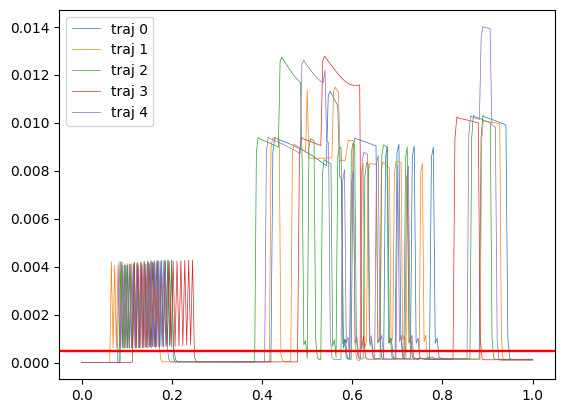

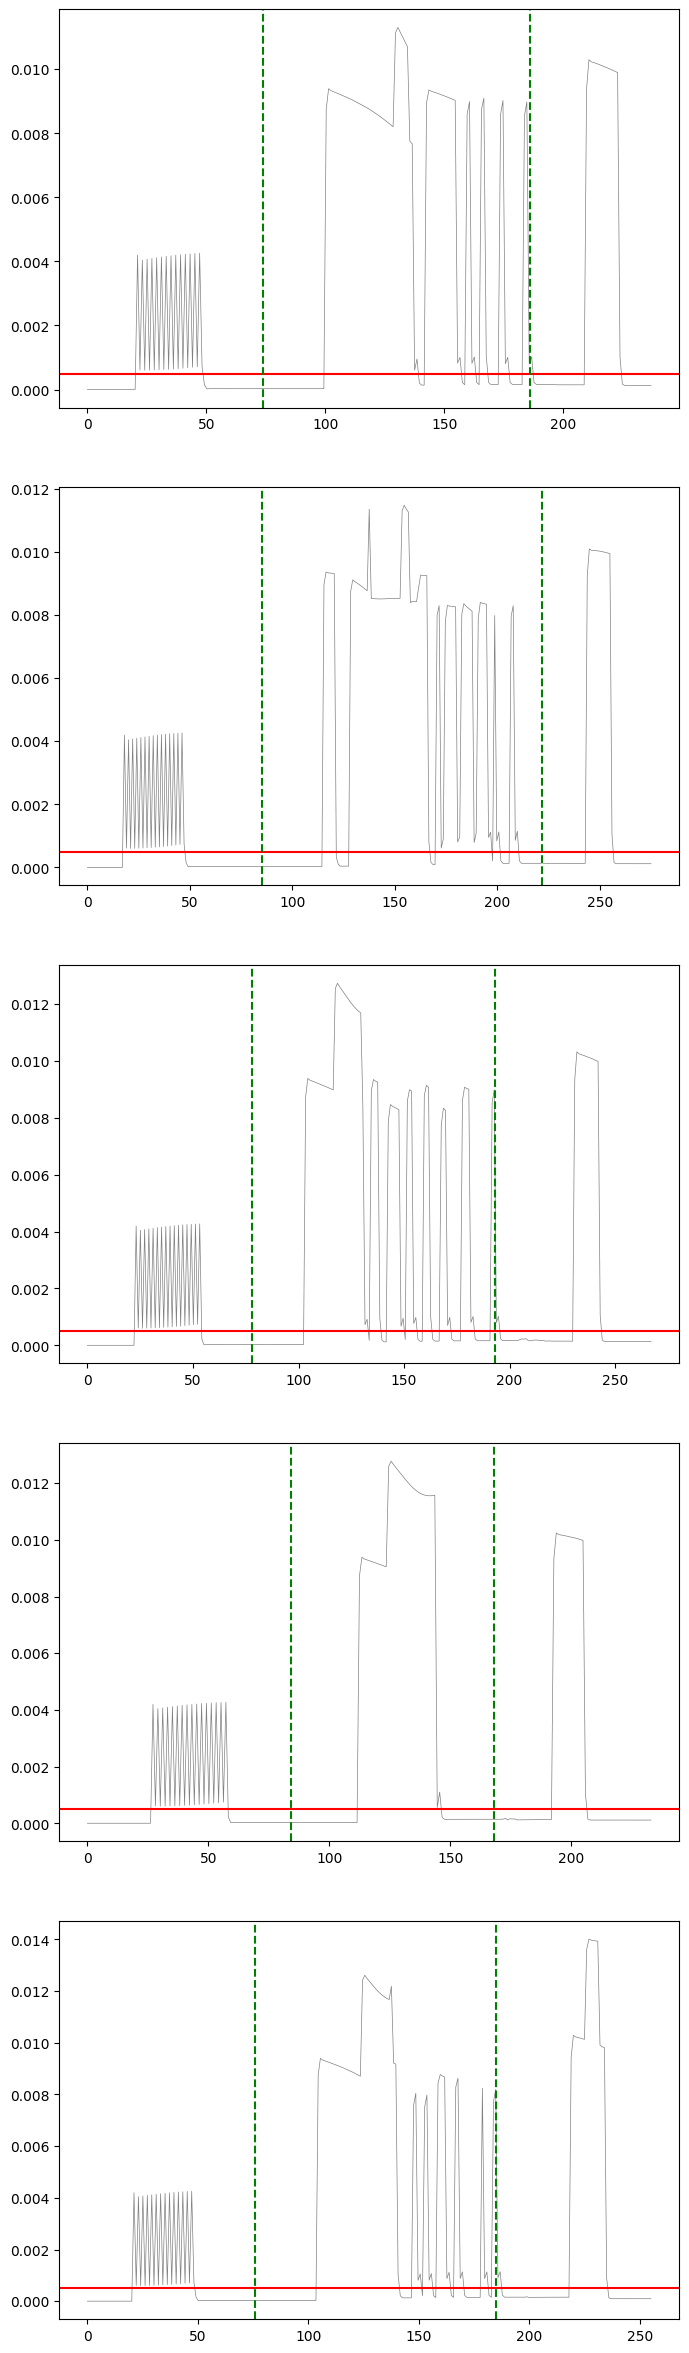

2025-08-03 19:23:50.066 | INFO     |  Creating segement of demos.
2025-08-03 19:23:50.069 | INFO     |  Subsampling to length 79 using strategy mean-length.
2025-08-03 19:23:50.071 | INFO     |  Creating segement of demos.
2025-08-03 19:23:50.074 | INFO     |  Subsampling to length 111 using strategy mean-length.
2025-08-03 19:23:50.076 | INFO     |  Creating segement of demos.
2025-08-03 19:23:50.079 | INFO     |  Subsampling to length 62 using strategy mean-length.
2025-08-03 19:23:50.080 | INFO     |  ... created 3 segments
2025-08-03 19:23:50.080 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:23:50.080 | INFO     |    Creating partial frame view of demos.
2025-08-03 19:23:50.084 | WARNING  |    Riemannian GMMs only make sense for rotations.
2025-08-03 19:23:50.084 | INFO     |    Manifold: TIME x R3 x R1
2025-08-03 19:23:50.084 | INFO     |    Changing number of components to 3
2025-08-03 19:23:50.085 | INFO     |    Model init ...


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.105 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:23:50.105 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.133 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:23:50.134 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.162 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:23:50.163 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.309 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:23:50.309 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.344 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:23:50.345 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.372 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:23:50.373 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.400 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:23:50.401 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.430 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:23:50.431 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.459 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:23:50.459 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:50.487 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-03 19:23:50.488 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-08-03 19:23:50.488 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-08-03 19:23:50.488 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-08-03 19:23:50.489 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:23:50.560 | INFO     |    Fitting candidate frame 1/10
2025-08-03 19:23:50.561 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.600 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:23:50.601 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.639 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:23:50.640 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.679 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:23:50.679 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.712 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:23:50.713 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.744 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:23:50.745 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.780 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:23:50.780 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.812 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:23:50.812 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.845 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:23:50.846 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:50.881 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:23:50.881 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-03 19:23:51.027 | INFO     |  ee_init    score (rel):     -0 (0.332)
2025-08-03 19:23:51.027 | INFO     |  obj000     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj001     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj002     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj003     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj004     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj005     score (rel):     -0 (0.332)
2025-08-03 19:23:51.028 | INFO     |  obj006     score (rel):     -0 (0.031)
2025-08-03 19:23:51.028 | INFO     |  obj007     score (rel):     -0 (1.000)
2025-08-03 19:23:51.028 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-08-03 19:23:51.029 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2025-08-03 19:23:51.029 | INFO     |  Adding frame 0 to segment 1.
2025-08-03 19:23:51.030 | INFO     |  Creating partial frame view of demo

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.168 | INFO     |    Fitting candidate frame 2/10
2025-08-03 19:23:51.169 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.196 | INFO     |    Fitting candidate frame 3/10
2025-08-03 19:23:51.197 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.224 | INFO     |    Fitting candidate frame 4/10
2025-08-03 19:23:51.224 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.254 | INFO     |    Fitting candidate frame 5/10
2025-08-03 19:23:51.255 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.296 | INFO     |    Fitting candidate frame 6/10
2025-08-03 19:23:51.297 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.341 | INFO     |    Fitting candidate frame 7/10
2025-08-03 19:23:51.341 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.373 | INFO     |    Fitting candidate frame 8/10
2025-08-03 19:23:51.373 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.400 | INFO     |    Fitting candidate frame 9/10
2025-08-03 19:23:51.400 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.432 | INFO     |    Fitting candidate frame 10/10
2025-08-03 19:23:51.433 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.472 | INFO     |  ee_init    score (rel):     -0 (0.284)
2025-08-03 19:23:51.472 | INFO     |  obj000     score (rel):     -0 (0.284)
2025-08-03 19:23:51.472 | INFO     |  obj001     score (rel):     -0 (0.284)
2025-08-03 19:23:51.473 | INFO     |  obj002     score (rel):     -0 (0.284)
2025-08-03 19:23:51.473 | INFO     |  obj003     score (rel):     -0 (0.284)
2025-08-03 19:23:51.473 | INFO     |  obj004     score (rel):     -0 (0.284)
2025-08-03 19:23:51.473 | INFO     |  obj005     score (rel):     -0 (0.284)
2025-08-03 19:23:51.473 | INFO     |  obj006     score (rel):     -0 (0.010)
2025-08-03 19:23:51.473 | INFO     |  obj008     score (rel):     -0 (0.001)
2025-08-03 19:23:51.474 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:23:51.476 | INFO     |  Segmented trajs into 3 segments
2025-08-03 19:23:51.487 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142855 -0.142855 -

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.525 | INFO     |  Manifold: TIME x R3 x R3 x R3 x R3 x R3 x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:51.576 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[2.01e+28, 2.01e+28, 1.94e+28, ..., 1.14e-25, 9.72e-27, 7.99e-28],
         [4.59e+26, 5.29e+26, 6.03e+26, ..., 3.26e+26, 2.72e+26, 2.24e+26],
         [9.61e-26, 1.08e-24, 1.18e-23, ..., 1.53e+28, 1.56e+28, 1.54e+28]]),
  array([[9.95e+006, 9.96e+006, 9.65e+006, ..., 7.93e-127, 2.82e-128,
          8.87e-132],
         [2.02e+005, 2.30e+005, 2.61e+005, ..., 3.82e-002, 2.87e-002,
          2.62e-002],
         [7.01e-031, 7.24e-031, 7.43e-031, ..., 5.49e+006, 4.83e+006,
          4.29e+006],
         [2.79e-161, 8.03e-160, 2.24e-158, ..., 3.47e+008, 3.53e+008,
          2.69e+008]]),
  array([[4.18e+05, 4.10e+05, 3.96e+05, 3.71e+05, 3.35e+05, 2.93e+05,
          2.48e+05, 2.04e+05, 1.62e+05, 1.24e+05, 9.25e+04, 6.66e+04,
          4.64e+04, 3.13e+04, 2.04e+04, 1.29e+04, 7.89e+03, 4.67e+03,
          2.67e+03, 1.48e+03, 7.96e+02, 4.13e+02, 2.08e+02, 1.01e+02,
          4.75e+01, 2.17e+01, 9.57e+00, 4.08e+00, 1.69e+00, 5.51e-01,
          1.47e-01, 5.54e-02, 1.19e-02, 2.11e-03, 

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-03 19:23:52.159 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-03 19:23:52.240 | WARNING  |  Skippig NaN Gaussians.


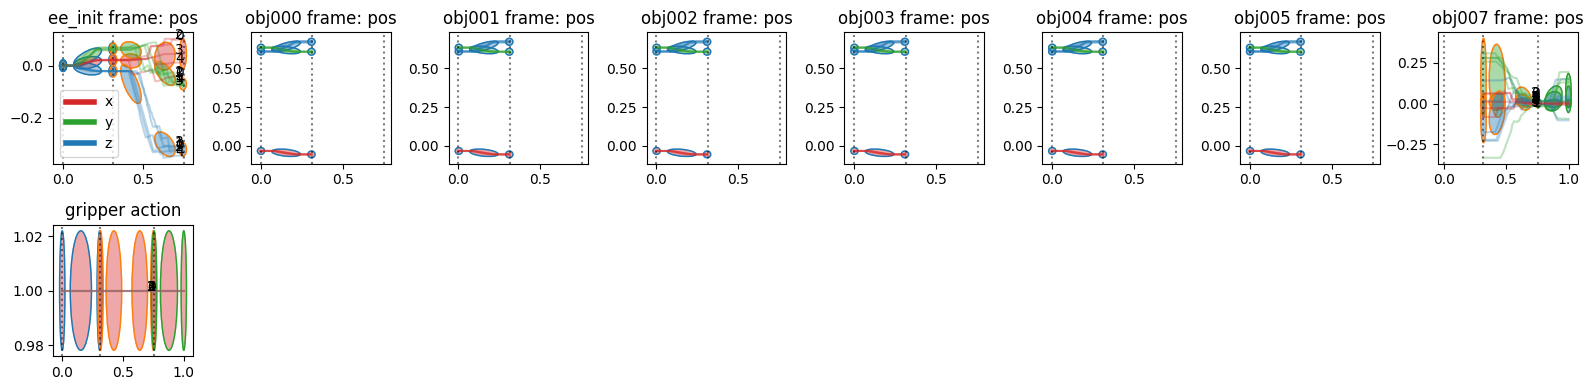

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-03 19:23:54.548 | INFO     |  Fitting AutoTPGMM
2025-08-03 19:23:54.549 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-03 19:23:54.559 | INFO     |  HMM EM ...
2025-08-03 19:23:54.560 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-03 19:23:54.583 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-03 19:23:54.721 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[3.68e-06, 1.36e-06, 4.30e-07, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.00e+00, 1.00e+00, 1.00e+00, ..., 8.60e-01, 6.81e-01, 3.97e-01],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.40e-01, 3.19e-01, 6.03e-01]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 9.94e-037, 1.77e-032, ..., 1.07e-298, 3.17e-311,
          0.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e-034, 9.20e-039,
          2.28e-041],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 9.98e-001, 9.81e-001, 8.84e-001, 6.19e-001,
          2.75e-001, 6.64e-002, 7.90e-003, 4.36e-004, 1.08e-005, 1.16e-007,
          5.30e-010, 1.02e-012, 8.10e-016, 2.60e-019, 3.34e-023, 1.34e-027,
          1.41e-032,

2025-08-03 19:23:56.787 | INFO     |  Did not specify time_based, deciding automatically.


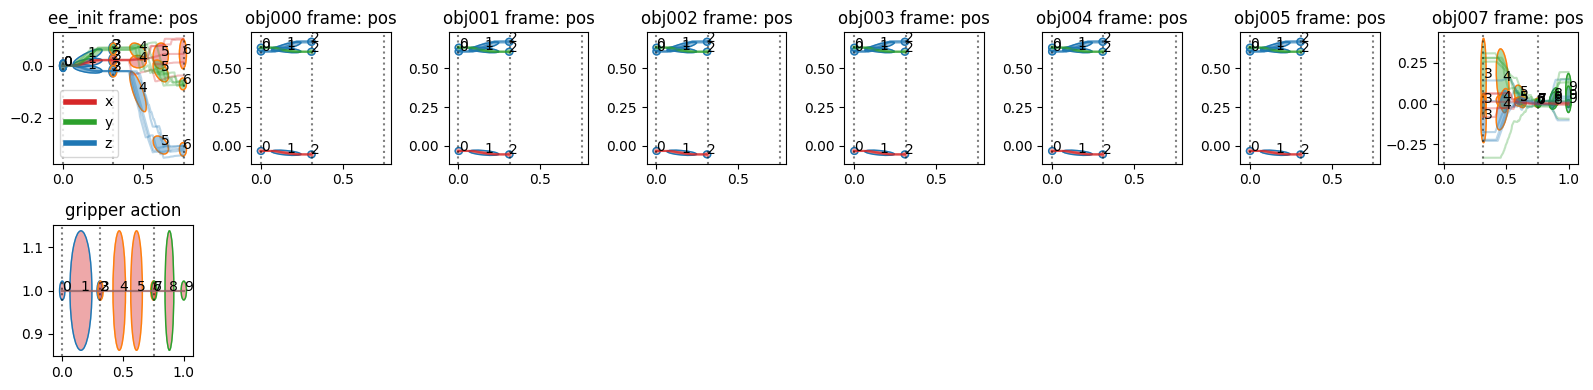

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

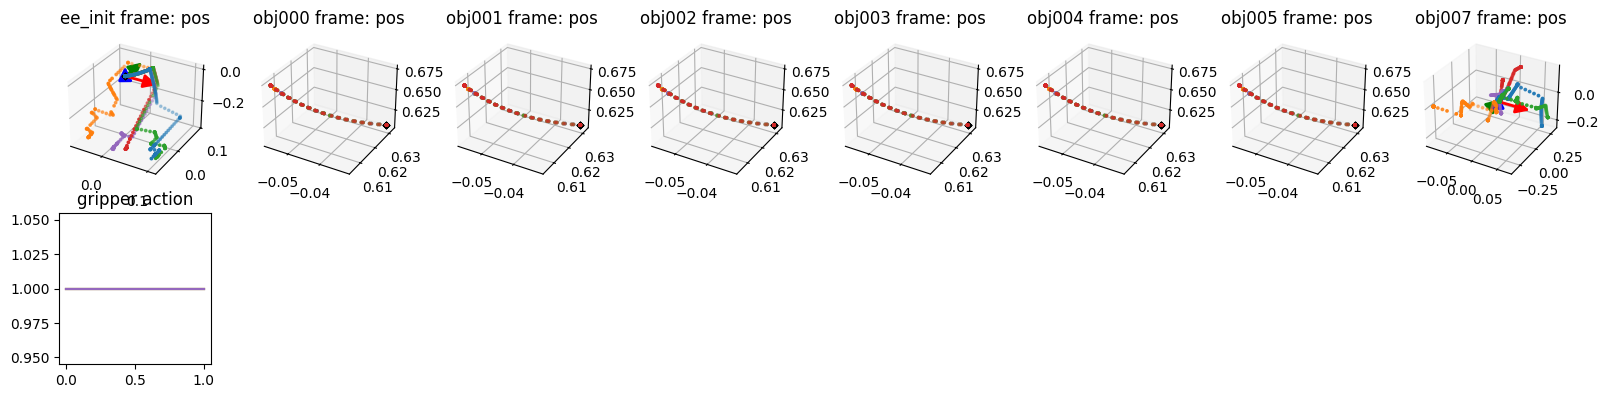

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

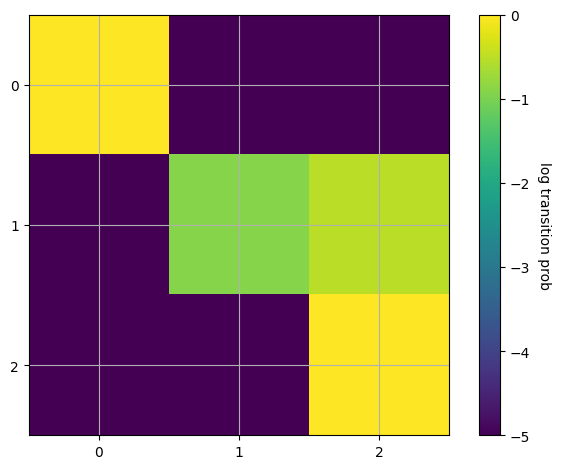

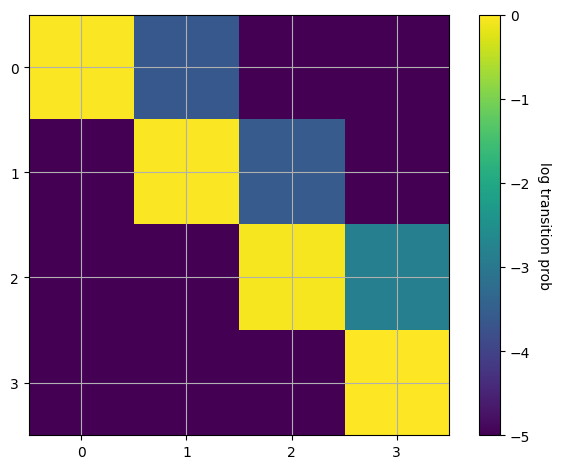

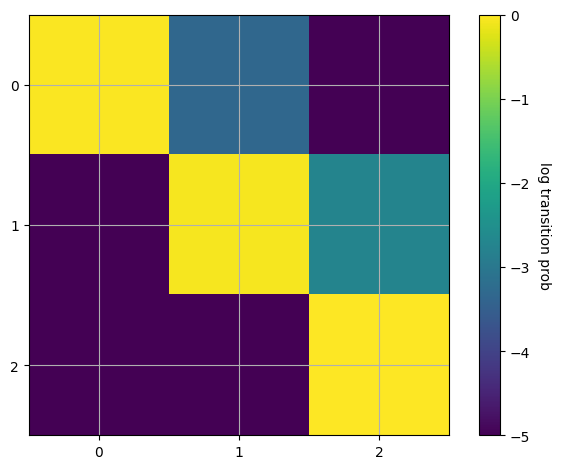

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-03 19:24:02.902 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-03 19:24:03.122 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-03 19:24:03.176 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[0.98]]))
2025-08-03 19:24:03.176 | INFO     |  Creating partial frame view of demos.
2025-08-03 19:24:03.287 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-03 19:24:03.394 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-03 19:24:03.557 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-03 19:24:03.656 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

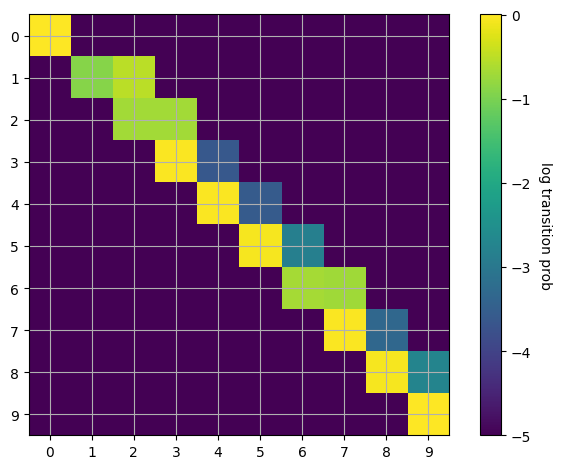

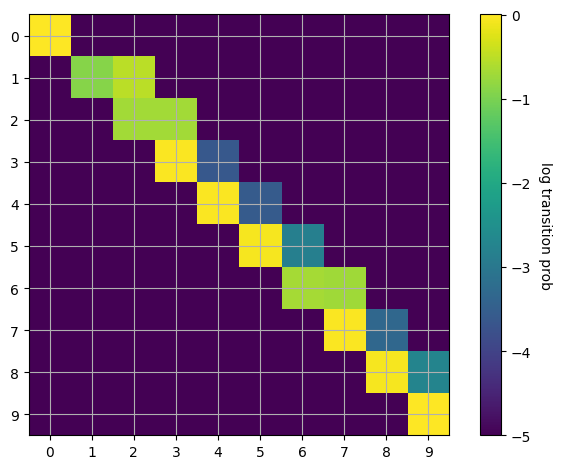

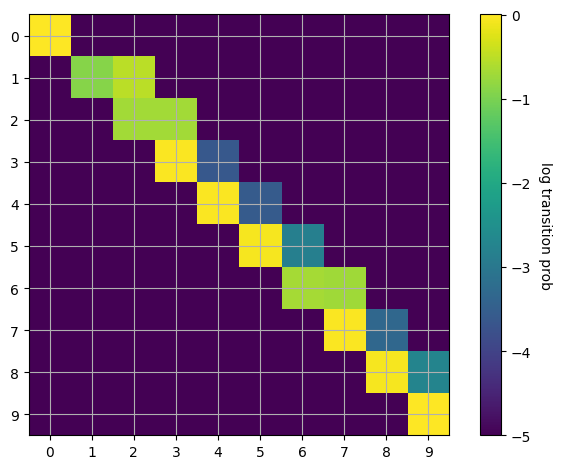

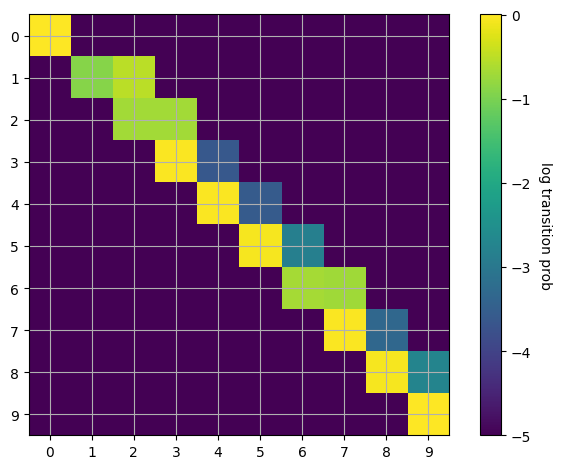

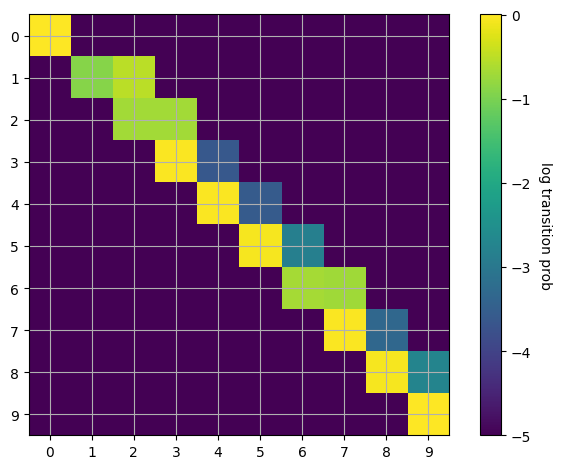

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-03 19:24:08.611 | INFO     |  Taking frame origins from demos.


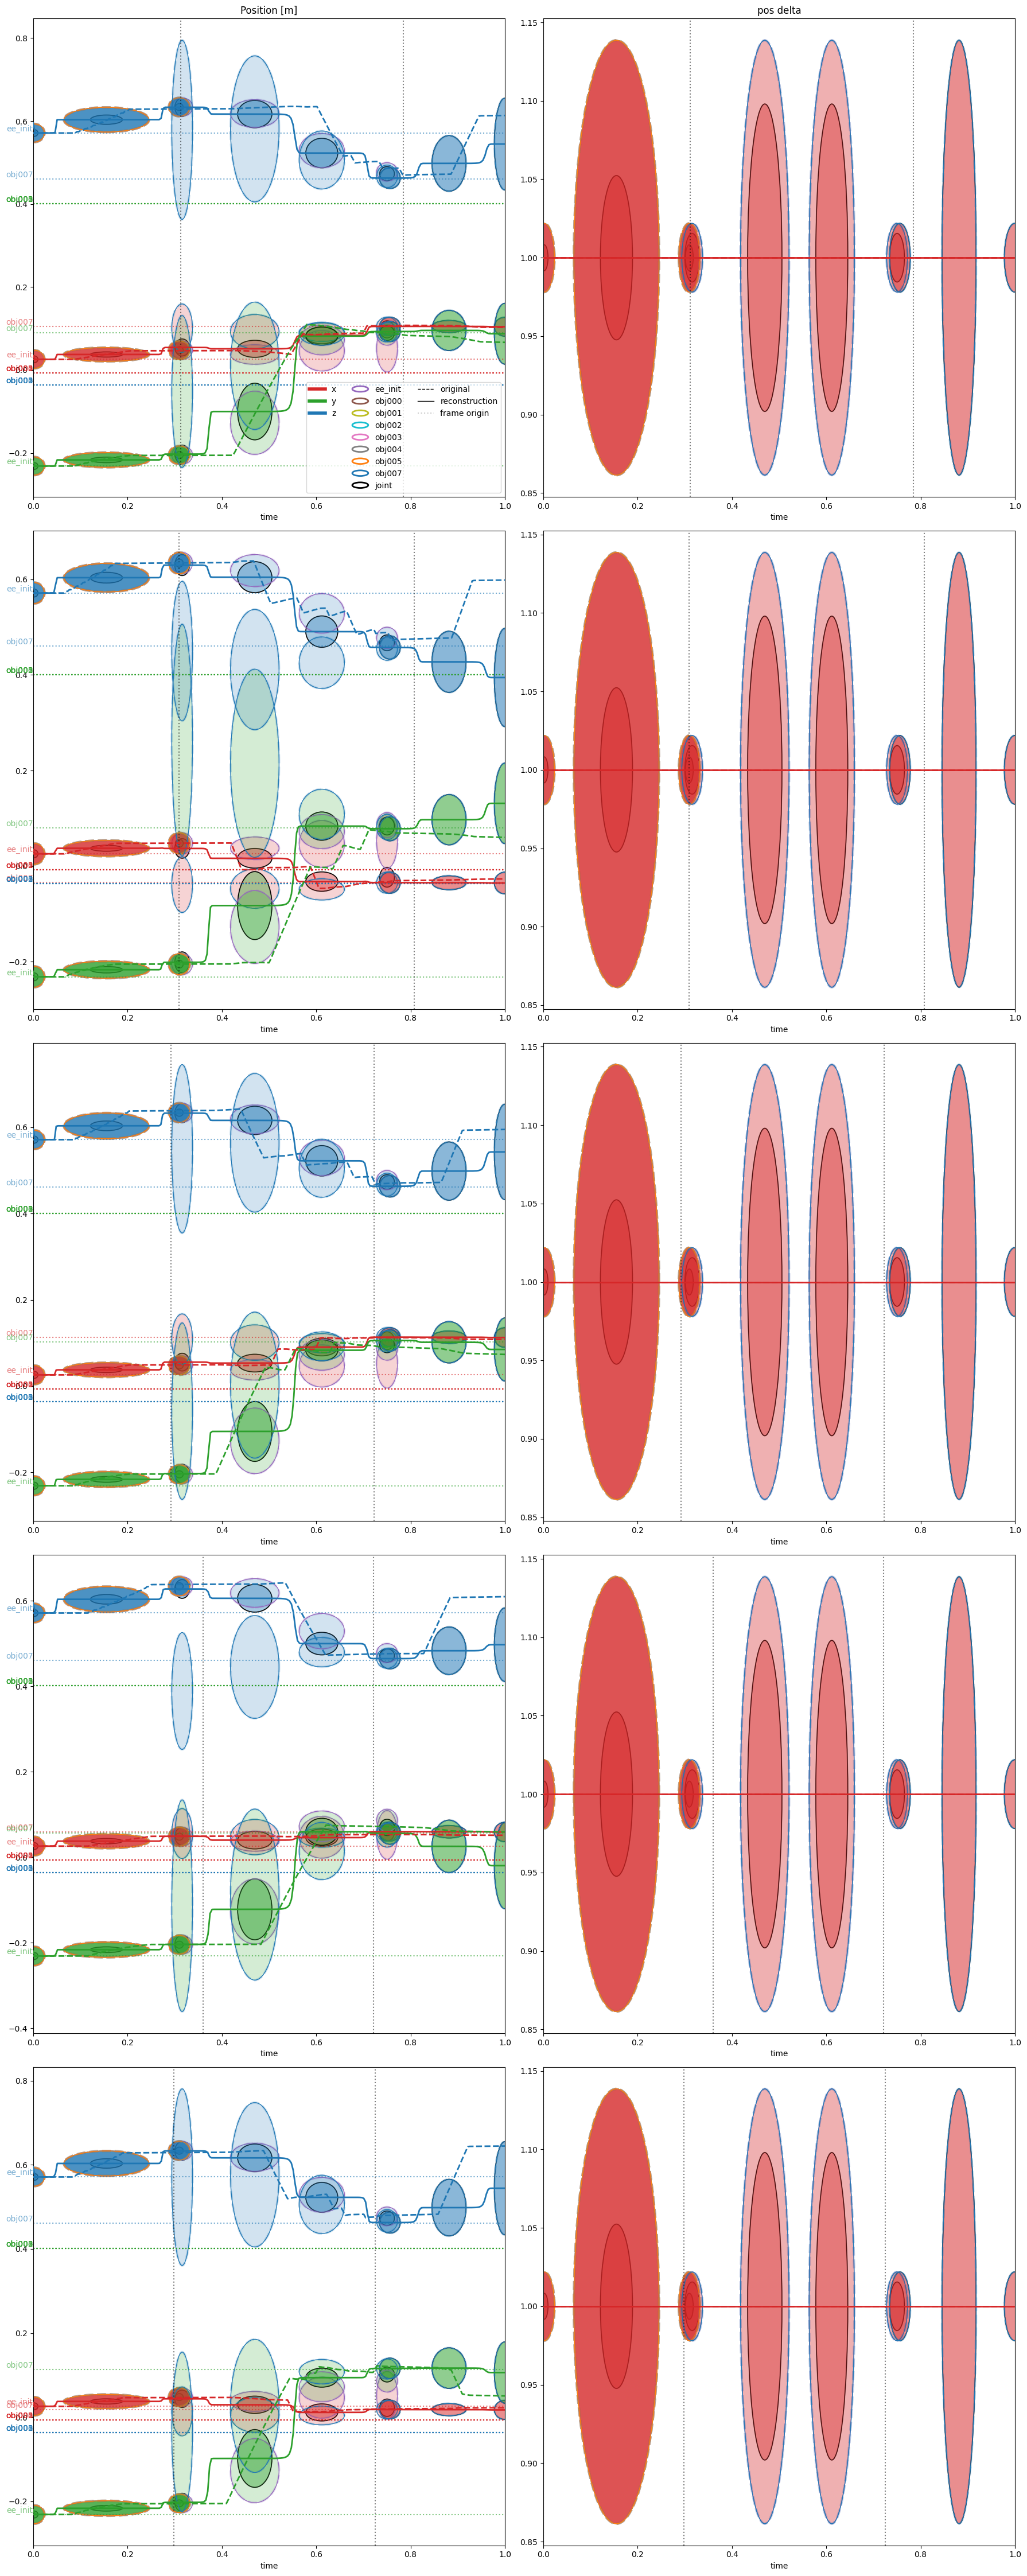

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range